# Band Math & Vegetation Indices

Band math is a way to combine bands of remotely sensed data to create new bands that highlight certain features. Calculations can be as simple as adding or subtracting bands, or more complex like calculating vegetation indices. Each operation is done on a per-pixel basis, so the output will have the same spatial extent and resolution as the input.

In [39]:
import rioxarray as rxr
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Load RGBN data
rgbn_path = "../../pygis/data/rgbn.tif"

## Band Math Basics

Rioxarray allows us to perform basic arithmetic operations on bands like addition, subtraction, multiplication, and division.

### Arithmetic Operations

We can perform basic arithmetic operations on bands. For example, we can combine the red and NIR bands to create a new band that highlights vegetation.

<xarray.DataArray (y: 403, x: 515)> Size: 208kB
array([[ 85, 171,   7, ..., 198, 189, 191],
       [146, 215, 199, ..., 202, 171, 144],
       [188, 213, 197, ..., 146, 114, 108],
       ...,
       [ 30,  36,  42, ..., 219,  29,  54],
       [250, 246,   1, ..., 244,  44,  28],
       [ 11, 186, 179, ...,  44,  30, 248]], shape=(403, 515), dtype=uint8)
Coordinates:
  * x            (x) float64 4kB 7.93e+05 7.93e+05 ... 7.956e+05 7.956e+05
  * y            (y) float64 3kB 2.05e+06 2.05e+06 ... 2.048e+06 2.048e+06
    spatial_ref  int64 8B 0


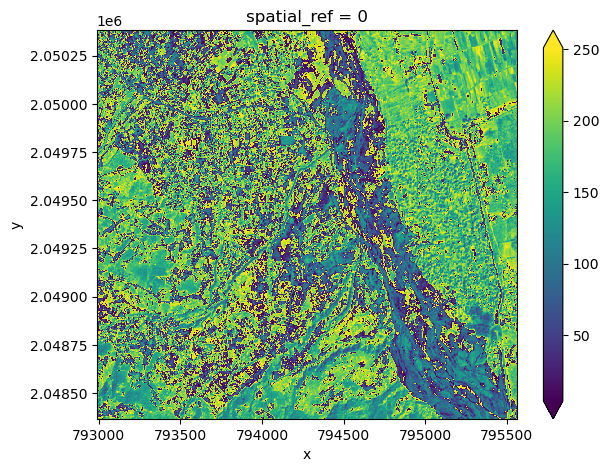

In [40]:
# Open RGBN data with band names
ds = rxr.open_rasterio(rgbn_path)
ds = ds.assign_coords(band=['red','green','blue','nir'])

# Calculate a new band adding the red and nir bands
fig, ax = plt.subplots(dpi=100)
add_nir_red = ds.sel(band='nir') + ds.sel(band='red')
add_nir_red.plot(robust=True, ax=ax)
print(add_nir_red)
plt.tight_layout(pad=1)

## Vegetation Indices

Healthy vegetation (with chlorophyll) reflects more near-infrared (NIR) and green light compared to other wavelengths and absorbs more red and blue light. We can use this effect to generate a number of vegetation indices.

### Enhanced Vegetation Index (EVI)

EVI is an index of vegetation that is optimized to improve sensitivity to high biomass and better handling of background and atmospheric influences. Let's start by looking at the original image in true color.

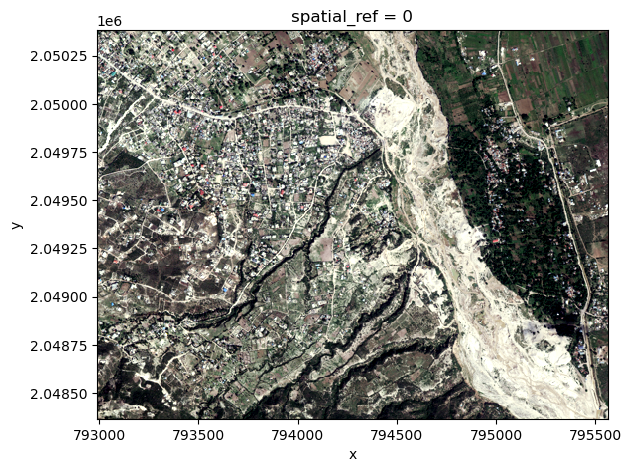

In [41]:
# True color visualization (blue, green, red order)
fig, ax = plt.subplots(dpi=100)
ds_scaled = ds * 0.0001  # Apply scale factor for visualization
ds_scaled.sel(band=['blue', 'green', 'red']).plot.imshow(robust=True)
plt.tight_layout(pad=1)

In [42]:
# Calculate EVI with scale factor (sensor='rgbn', scale_factor=0.0001)
def calculate_evi(ds, scale_factor=0.0001):
    """Calculate Enhanced Vegetation Index (EVI)"""
    ds_scaled = ds * scale_factor
    
    nir = ds_scaled.sel(band='nir')
    red = ds_scaled.sel(band='red') 
    blue = ds_scaled.sel(band='blue')
    
    # EVI coefficients for rgbn sensor
    G = 2.5
    C1 = 6.0
    C2 = 7.5
    L = 1.0
    
    numerator = nir - red
    denominator = nir + C1 * red - C2 * blue + L
    
    evi = xr.where(denominator != 0, G * (numerator / denominator), np.nan)
    evi = evi.assign_coords(band='evi').expand_dims('band')
    
    return evi

# Load and calculate EVI
ds = rxr.open_rasterio(rgbn_path)
ds = ds.assign_coords(band=['red','green','blue','nir'])
print(ds)

evi = calculate_evi(ds, scale_factor=0.0001)
print(evi)

<xarray.DataArray (band: 4, y: 403, x: 515)> Size: 830kB
[830180 values with dtype=uint8]
Coordinates:
  * x            (x) float64 4kB 7.93e+05 7.93e+05 ... 7.956e+05 7.956e+05
  * y            (y) float64 3kB 2.05e+06 2.05e+06 ... 2.048e+06 2.048e+06
    spatial_ref  int64 8B 0
  * band         (band) <U5 80B 'red' 'green' 'blue' 'nir'
Attributes:
    DataType:            Generic
    AREA_OR_POINT:       Area
    RepresentationType:  ATHEMATIC
    scale_factor:        1.0
    add_offset:          0.0
<xarray.DataArray (band: 1, y: 403, x: 515)> Size: 2MB
array([[[-0.00919483,  0.00224528, -0.00126384, ...,  0.00801965,
          0.00427393,  0.00276563],
        [ 0.00446938,  0.01463294, -0.00680684, ...,  0.0050355 ,
         -0.00278031, -0.00555191],
        [ 0.00992999,  0.01317359,  0.00175844, ..., -0.00403796,
         -0.01268199, -0.01164203],
        ...,
        [ 0.00305157,  0.00051088, -0.00307834, ...,  0.00972666,
         -0.00381874, -0.01179185],
        [ 0.0035

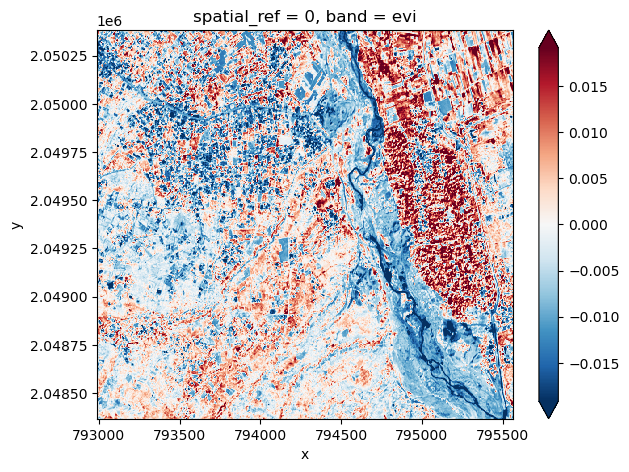

In [43]:
# Plot EVI
fig, ax = plt.subplots(dpi=100)
ds_scaled = ds * 0.0001
ds_scaled.sel(band=['blue', 'green', 'red']).plot.imshow(robust=True)
evi.plot(robust=True)
plt.tight_layout(pad=1)

### Two-band Enhanced Vegetation Index (EVI2)

We can also calculate an approximation of EVI with two bands. This allows us to extend EVI calculations back in time using AVHRR, and avoids some problems with the blue band which tends to be noisy.

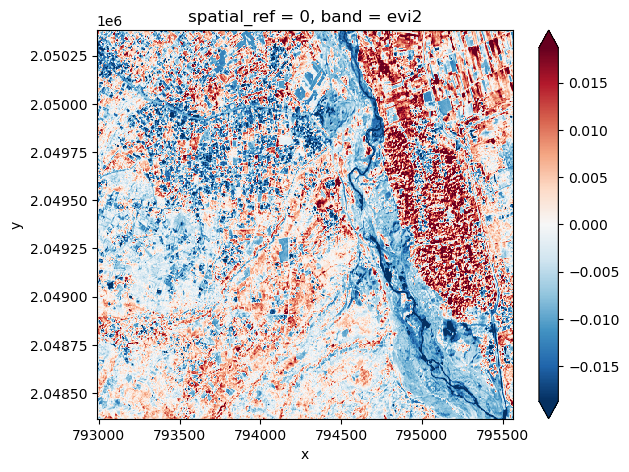

In [44]:
def calculate_evi2(ds, scale_factor=0.0001):
    """Calculate Two-band Enhanced Vegetation Index (EVI2)"""
    ds_scaled = ds * scale_factor
    
    nir = ds_scaled.sel(band='nir')
    red = ds_scaled.sel(band='red')
    
    G = 2.5
    L = 1.0
    C = 2.4
    
    numerator = nir - red
    denominator = L + nir + C * red
    
    evi2 = xr.where(denominator != 0, G * (numerator / denominator), np.nan)
    evi2 = evi2.assign_coords(band='evi2').expand_dims('band')
    
    return evi2

fig, ax = plt.subplots(dpi=100)
evi2 = calculate_evi2(ds, scale_factor=0.0001)
evi2.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)

### Normalized Difference Vegetation Index (NDVI)

The simplest vegetation metric is NDVI, which is just the normalized difference between the Red and NIR bands. We can calculate it using the generic norm_diff function for any two-band combination.

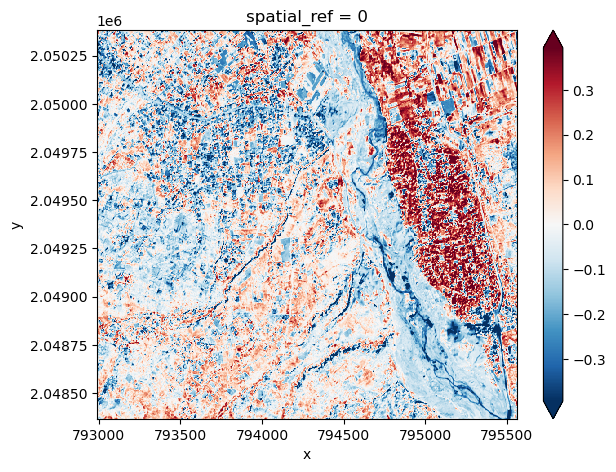

In [45]:
def norm_diff(ds, band1, band2, scale_factor=0.0001):
    """Generic normalized difference function for any two bands"""
    # Convert to reflectance first
    ds_scaled = ds * scale_factor
    
    b1 = ds_scaled.sel(band=band1)
    b2 = ds_scaled.sel(band=band2)
    
    numerator = b1 - b2
    denominator = b1 + b2
    
    result = xr.where(denominator != 0, numerator / denominator, np.nan)
    return result

fig, ax = plt.subplots(dpi=100)
ndvi = norm_diff(ds, 'nir', 'red', scale_factor=0.0001)
ndvi.plot(robust=True)
plt.tight_layout(pad=1)

### Tasseled Cap Transformations

Tasseled cap transform uses a linear equation to try to differentiate different components of the spectrum that are of interest for vegetation dynamics such as phenological stages. The output includes three bands including brightness, greenness for vegetation, and wetness as an indicator of soil and canopy moisture.

bands ['brightness' 'greenness' 'wetness']


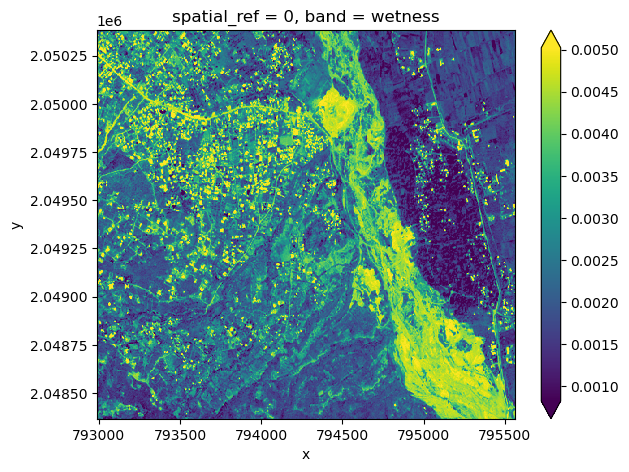

In [46]:
def calculate_tasseled_cap(ds, scale_factor=0.0001):
    """Calculate Tasseled Cap Transformation (sensor='qb', scale_factor=0.0001)"""
    ds_scaled = ds * scale_factor
    
    red = ds_scaled.sel(band='red')
    green = ds_scaled.sel(band='green') 
    blue = ds_scaled.sel(band='blue')
    nir = ds_scaled.sel(band='nir')
    
    # QuickBird (qb) coefficients
    brightness_coeffs = [0.319, 0.542, 0.490, 0.604]
    greenness_coeffs = [-0.121, -0.331, -0.517, 0.780]
    wetness_coeffs = [0.652, 0.375, -0.639, -0.163]
    
    bands = [red, green, blue, nir]
    
    brightness = sum(coeff * band for coeff, band in zip(brightness_coeffs, bands))
    greenness = sum(coeff * band for coeff, band in zip(greenness_coeffs, bands))
    wetness = sum(coeff * band for coeff, band in zip(wetness_coeffs, bands))
    
    brightness = brightness.assign_coords(band='brightness').expand_dims('band')
    greenness = greenness.assign_coords(band='greenness').expand_dims('band')
    wetness = wetness.assign_coords(band='wetness').expand_dims('band')
    
    tcap = xr.concat([brightness, greenness, wetness], dim='band')
    return tcap

fig, ax = plt.subplots(dpi=100)
tcap = calculate_tasseled_cap(ds, scale_factor=0.0001)
print('bands', tcap.band.values)
tcap.sel(band='wetness').plot(robust=True, ax=ax)
plt.tight_layout(pad=1)

## Comparison of Vegetation Indices

Let's compare all the vegetation indices side by side.

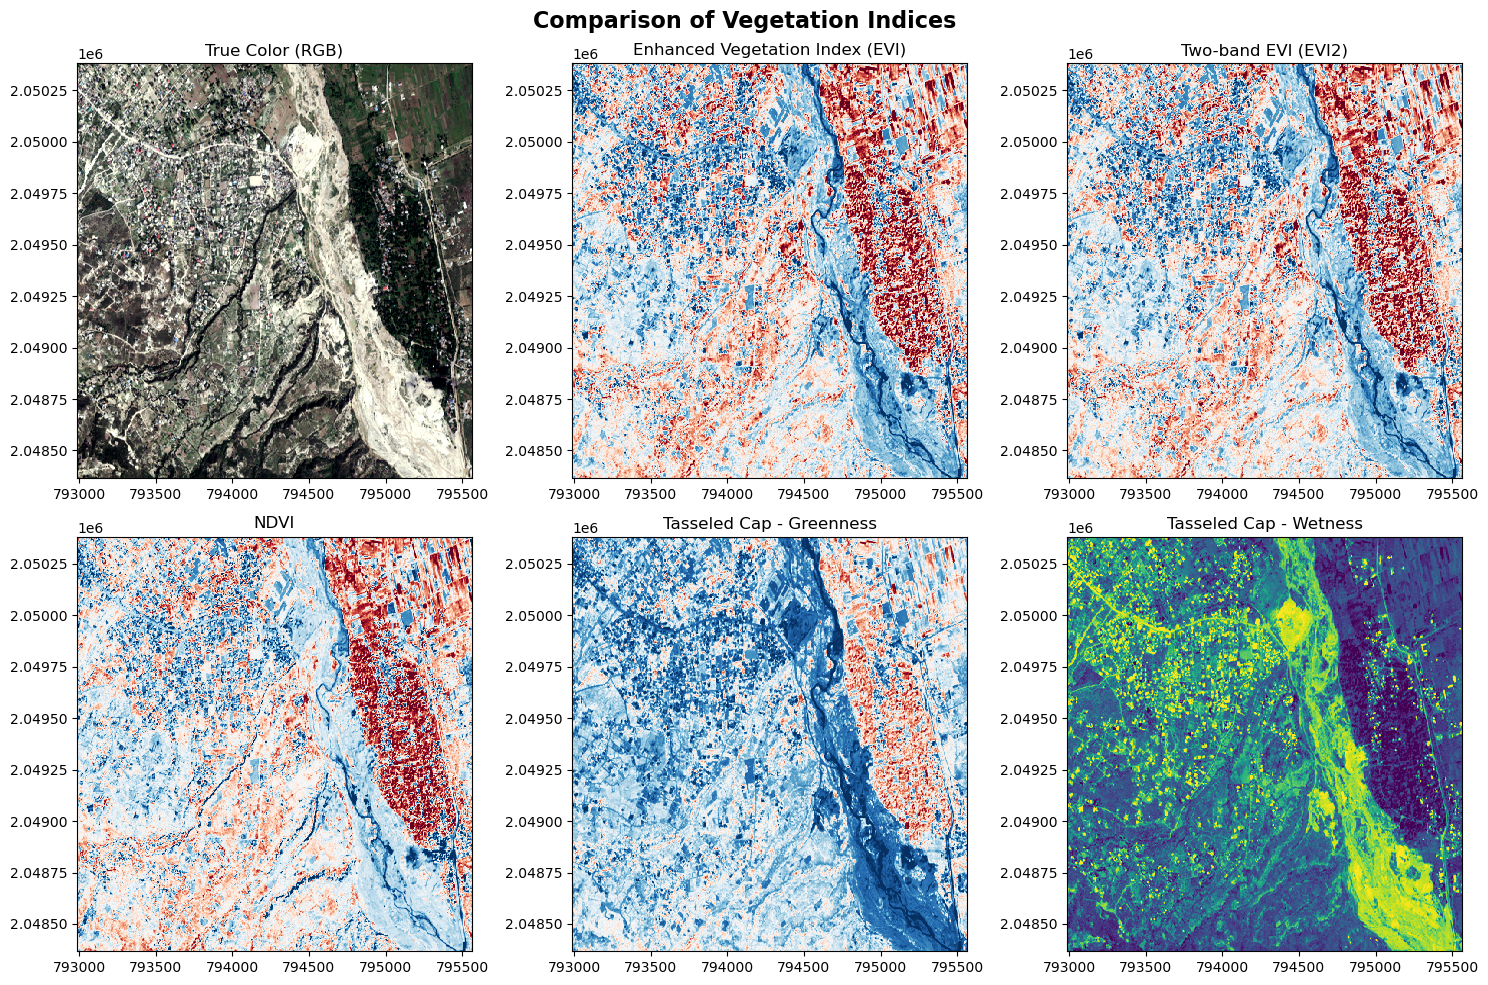

In [48]:
# Calculate all indices
ds = rxr.open_rasterio(rgbn_path)
ds = ds.assign_coords(band=['red','green','blue','nir'])

evi_result = calculate_evi(ds, scale_factor=0.0001)
evi2_result = calculate_evi2(ds, scale_factor=0.0001)
ndvi_result = norm_diff(ds, 'nir', 'red')
tcap_result = calculate_tasseled_cap(ds, scale_factor=0.0001)

# Create comparison plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=100)
axes = axes.flatten()

# True color (blue, green, red order with scaling)
ds_scaled = ds * 0.0001
ds_scaled.sel(band=['blue', 'green', 'red']).plot.imshow(robust=True, ax=axes[0])
axes[0].set_title('True Color (RGB)')

# EVI
evi_result.plot(robust=True, ax=axes[1], add_colorbar=False)
axes[1].set_title('Enhanced Vegetation Index (EVI)')

# EVI2
evi2_result.plot(robust=True, ax=axes[2], add_colorbar=False)
axes[2].set_title('Two-band EVI (EVI2)')

# NDVI
ndvi_result.plot(robust=True, ax=axes[3], add_colorbar=False)
axes[3].set_title('NDVI')

# Tasseled Cap - Greenness
tcap_result.sel(band='greenness').plot(robust=True, ax=axes[4], add_colorbar=False)
axes[4].set_title('Tasseled Cap - Greenness')

# Tasseled Cap - Wetness
tcap_result.sel(band='wetness').plot(robust=True, ax=axes[5], add_colorbar=False)
axes[5].set_title('Tasseled Cap - Wetness')

# Remove axis labels for cleaner look
for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.suptitle('Comparison of Vegetation Indices', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

| Index | What High Values Mean | What Low Values Mean | Primary Use | Key Advantages | Limitations |
|-------|---------------------|-------------------|-------------|----------------|-------------|
| **True Color (RGB)** | Bright surfaces (urban areas, bare soil) | Dark surfaces (dense vegetation, water) | Visual interpretation and context | Natural appearance, easy interpretation | No quantitative vegetation analysis |
| **NDVI** | Healthy vegetation with strong NIR reflectance | Non-vegetated areas, water bodies | Basic vegetation mapping and monitoring | Simple calculation, widely used, good baseline | Saturates in dense vegetation, sensitive to atmosphere |
| **EVI** | Healthy, dense vegetation | Non-vegetated surfaces (buildings, roads, bare ground) | Precise biomass estimation, dense vegetation areas | Reduces atmospheric effects, better for high biomass | Requires blue band, more complex calculation |
| **EVI2** | Vigorous vegetation | Non-vegetated or stressed vegetation areas | Historical analysis with older satellites | Works without blue band, extends temporal coverage | Less accurate than full EVI, approximation only |
| **Tasseled Cap - Greenness** | Dense, healthy vegetation | Sparse vegetation, bare soil, urban surfaces | Vegetation abundance and vigor assessment | Linear transformation, multiple spectral components | Sensor-specific coefficients required |
| **Tasseled Cap - Wetness** | High moisture content (wetlands, water bodies) | Dry surfaces | Moisture mapping, drought monitoring | Sensitive to water content, complements vegetation indices | Complex interpretation, multiple factors affect values |

**Why EVI2 was needed**: EVI requires blue, red, and NIR bands, but many older satellites (like AVHRR) only had red and NIR bands. EVI2 approximates EVI performance using only two bands, enabling vegetation monitoring across longer time periods and different satellite missions.

## Common Band Combinations for Landsat 8

| Name    | Band Combination    |
| :--- | ---: |
| Natural Color    | 4 3 2  |
| False Color (urban) |  7 6 4|
| Color Infrared (vegetation) |	5 4 3|
| Agriculture |	6 5 2|
| Atmospheric Penetration |	7 6 5|
| Healthy Vegetation |	5 6 2 |
| Land/Water |	5 6 4|
| Natural With Atmospheric Removal |	7 5 3 |
|Shortwave Infrared |	7 5 4|
|Vegetation Analysis| 	6 5 4|